In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from tensorflow.keras import optimizers

In [30]:
import os
os.getcwd()

'/home/jupyter-jiayu'

## Load train and test from .csv

### 1. Load all data into cpu

In [13]:
# load input
input_train = []
with open('input_train.csv') as csvfile: 
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC)
    for row in reader: 
        input_train.append(row) 
input_train = np.array(input_train)

In [14]:
print(input_train.shape)
type(input_train[0][0])

(18542, 1421)


numpy.float64

In [15]:
input_test = []
with open('input_test.csv') as csvfile: 
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC)
    for row in reader: 
        input_test.append(row)
input_test = np.array(input_test)

In [16]:
print(input_test.shape)
type(input_test[0][0])

(4636, 1421)


numpy.float64

In [17]:
# load output
output_train = []
with open('output_train-1.csv') as csvfile: 
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC)
    for row in reader: 
        output_train.append(row)     
output_train = np.array(output_train)

In [18]:
print(output_train.shape)
type(output_train[0][0])

(18542, 10)


numpy.float64

In [19]:
output_test = []
with open('output_test-1.csv') as csvfile: 
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC)
    for row in reader: 
        output_test.append(row)  
output_test = np.array(output_test)

In [20]:
print(output_test.shape)
type(output_test[0][0])

(4636, 10)


numpy.float64

## Setup Random grid search

In [63]:
# define paramter space for random search
lr_range = [1e-2, 1e-3, 1e-4]
l1_range = [1e-5, 1e-7, 1e-9, 1e-11]
l2_range = [1e-5, 1e-7, 1e-9, 1e-11]
width_range = [64, 128]

In [64]:
# generate all possible combination = 4*4*3*2 = 96
comb_list = []
for a in lr_range: 
    for b in l1_range: 
        for c in l2_range: 
            for d in width_range: 
                temp = [a, b, c, d]
                comb_list.append(temp)

In [65]:
comb_list[0]

[0.01, 1e-05, 1e-05, 64]

In [67]:
# random NAS on a single target gene
def DnnRandomSearch(lr, l1, l2, width, x_train, y_train, x_test, y_test): 
    model = tf.keras.Sequential([
        # input layer
        tf.keras.layers.Dense(width, activation='relu', input_shape=(1421,), 
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)),

        #hidden layers
        tf.keras.layers.Dense(width, activation='relu', 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)),
        tf.keras.layers.Dense(width, activation='relu', 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)),

        # output layer
        tf.keras.layers.Dense(1, activation='linear')
    ])
    
    sgd = optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    
    model.compile(
        optimizer = sgd,
        loss = 'mean_squared_error',
        metrics = ['mse']
    )
    
    History = model.fit(
        verbose = 0,
        x = x_train,
        y = y_train,
        epochs = 30, 
        batch_size = 32, 
    #     callbacks = callbacks, 
        validation_data = (x_test, y_test)
    )
    
    del model
    return [History.history['val_mse'][-1], History.history['val_loss'][-1]]

In [68]:
# run random search and record results 
import time
VAL_MSE_RAND = []
VAL_LOSS_RAND = []
target_gene_train = output_train[:, 2]
target_gene_test = output_test[:, 2]
start_time = time.time()
for count, i in enumerate(comb_list): 
    lr, l1, l2, width = i[0], i[1], i[2], i[3]
    temp = DnnRandomSearch(lr, l1, l2, width, input_train, target_gene_train, 
                                                input_test, target_gene_test)
    VAL_MSE_RAND.append(temp[0])
    VAL_LOSS_RAND.append(temp[1])
    current_time = time.time()
    if count % 5 == 0: 
        print('%d random searches completed, %f seconds passed, %d more searches need to be done' 
             %(count+1, current_time - start_time, len(comb_list) - count - 1))

1 random searches completed, 78.385751 seconds passed, 95 more searches need to be done
6 random searches completed, 478.091264 seconds passed, 90 more searches need to be done
11 random searches completed, 875.039357 seconds passed, 85 more searches need to be done
16 random searches completed, 1273.391958 seconds passed, 80 more searches need to be done
21 random searches completed, 1673.381538 seconds passed, 75 more searches need to be done
26 random searches completed, 2071.751407 seconds passed, 70 more searches need to be done
31 random searches completed, 2469.745740 seconds passed, 65 more searches need to be done
36 random searches completed, 2869.361582 seconds passed, 60 more searches need to be done
41 random searches completed, 3268.328574 seconds passed, 55 more searches need to be done
46 random searches completed, 3667.725464 seconds passed, 50 more searches need to be done
51 random searches completed, 4066.543518 seconds passed, 45 more searches need to be done
56 ra

In [69]:
np.savetxt('val_mse_rand.txt', VAL_MSE_RAND)
np.savetxt('val_loss_rand.txt', VAL_LOSS_RAND)

In [70]:
np.savetxt('comb_list.txt', comb_list)

In [73]:
np.where(VAL_MSE_RAND==np.min(VAL_MSE_RAND))

(array([3]),)

In [78]:
comb_list[3]

[0.01, 1e-05, 1e-07, 128]

In [ ]:
7622 / 60 / 60

## Build DNN models

In [83]:
# training for 10 different genes 
def DNN_train(output_gene_train, output_gene_test):
    model = tf.keras.Sequential([
        # input layer
        tf.keras.layers.Dense(128, activation='relu', input_shape=(1421,), 
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-7)),

        #hidden layers
        tf.keras.layers.Dense(128, activation='relu', 
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-7)),
        tf.keras.layers.Dense(128, activation='relu', 
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-7)),

        # output layer
        tf.keras.layers.Dense(1, activation='linear')
    ])

    sgd = optimizers.SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(
        optimizer = sgd,
        loss = 'mean_squared_error',
        metrics = ['mse']
    )

    History = model.fit(
        x = input_train,
        y = output_gene_train,
        epochs = 30, 
        batch_size = 32, 
    #     callbacks = callbacks, 
        validation_data = (input_test, output_gene_test)
    )
    
    del model
    return [History.history['val_mse'][-1], History.history['val_loss'][-1]]

In [ ]:
VAL_LOSE_OPTIMAL_RAND = []
VAL_MSE_OPTIMAL_RAND = []
for i in range(output_train.shape[1]): 
    temp = DNN_train(output_train[:, i], output_test[:, i])
    VAL_MSE_OPTIMAL_RAND.append(temp[0])
    VAL_LOSE_OPTIMAL_RAND.append(temp[1])

Train on 18542 samples, validate on 4636 samples
Epoch 1/30
18542/18542 [==============================] - 3s 177us/sample - loss: 0.0811 - mse: 8.3834e-06 - val_loss: 0.0805 - val_mse: 7.9696e-06
Epoch 2/30
18542/18542 [==============================] - 3s 148us/sample - loss: 0.0799 - mse: 8.2379e-06 - val_loss: 0.0793 - val_mse: 7.9381e-06
Epoch 3/30
18542/18542 [==============================] - 3s 147us/sample - loss: 0.0787 - mse: 8.2356e-06 - val_loss: 0.0781 - val_mse: 8.0693e-06
Epoch 4/30
18542/18542 [==============================] - 3s 147us/sample - loss: 0.0775 - mse: 8.2352e-06 - val_loss: 0.0769 - val_mse: 8.1533e-06
Epoch 5/30
18542/18542 [==============================] - 3s 147us/sample - loss: 0.0763 - mse: 8.2411e-06 - val_loss: 0.0757 - val_mse: 7.9485e-06
Epoch 6/30
18542/18542 [==============================] - 3s 152us/sample - loss: 0.0751 - mse: 8.2528e-06 - val_loss: 0.0745 - val_mse: 7.9653e-06
Epoch 7/30
18542/18542 [==============================] - 3s 14

In [ ]:
np.savetxt('val_mse_optimal_rand.txt', VAL_MSE_OPTIMAL_RAND)
np.savetxt('val_loss_optimal_rand.txt', VAL_LOSE_OPTIMAL_RAND)

In [ ]:
def plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, color='blue', label='Train')
    plt.plot(epochs, val_acc, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    _ = plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, color='blue', label='Train')
    plt.plot(epochs, val_loss, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

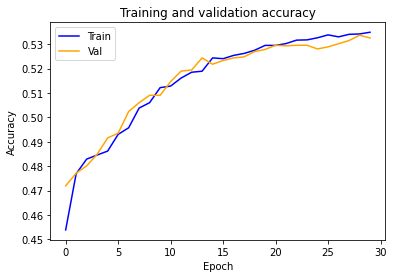

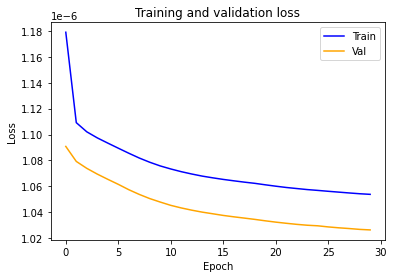

In [29]:
plot(History)